<a href="https://colab.research.google.com/github/bernicegolomo/Facial-Recognition_ML/blob/main/Facial_Recognition_based_Staff_Attendance_System_using_InceptionV3_and_Transfer_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Setup and Imports**

In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_lfw_people
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, precision_score, f1_score, ConfusionMatrixDisplay
import tensorflow as tf
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from sklearn.metrics.pairwise import cosine_similarity
from PIL import Image
import requests
from io import BytesIO

# **Dataset Loading and Preprocessing**

In [16]:
# Load the LFW dataset
print("Loading dataset...")
lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)
X = lfw_people.data
y = lfw_people.target
target_names = lfw_people.target_names
n_classes = target_names.shape[0]

# Preprocess the data
X = X.reshape((X.shape[0], 50, 37, 1))  # Reshape for CNN input
X = np.tile(X, (1, 1, 1, 3))  # Convert grayscale to RGB
X = X.astype('float32') / 255  # Normalize the pixel values

# Resize images to fit InceptionV3 input requirements (150x150 pixels)
X_resized = tf.image.resize(X, [150, 150]).numpy()

# Split the dataset into training and testing sets
print("Splitting data into training and testing sets...")
X_train, X_test, y_train, y_test = train_test_split(X_resized, y, test_size=0.2, random_state=42)
print("Data split successfully!")


# Explore Dataset Properties
print(f"Data Shape: {X.shape}")
print(f"Number of Samples: {X.shape[0]}")
print(f"Number of Features (pixels): {X.shape[1]}")
print("Target Names:", y)


for i in range(10):
    print(f"Sample {i}: Class Name - {target_names[y[i]]}, Target Label - {y[i]}")


Loading dataset...
Splitting data into training and testing sets...
Data split successfully!
Data Shape: (1288, 50, 37, 3)
Number of Samples: 1288
Number of Features (pixels): 50
Target Names: [5 6 3 ... 5 3 5]
Sample 0: Class Name - Hugo Chavez, Target Label - 5
Sample 1: Class Name - Tony Blair, Target Label - 6
Sample 2: Class Name - George W Bush, Target Label - 3
Sample 3: Class Name - Colin Powell, Target Label - 1
Sample 4: Class Name - Ariel Sharon, Target Label - 0
Sample 5: Class Name - Colin Powell, Target Label - 1
Sample 6: Class Name - George W Bush, Target Label - 3
Sample 7: Class Name - Gerhard Schroeder, Target Label - 4
Sample 8: Class Name - George W Bush, Target Label - 3
Sample 9: Class Name - Ariel Sharon, Target Label - 0


# **Display Sample Images**

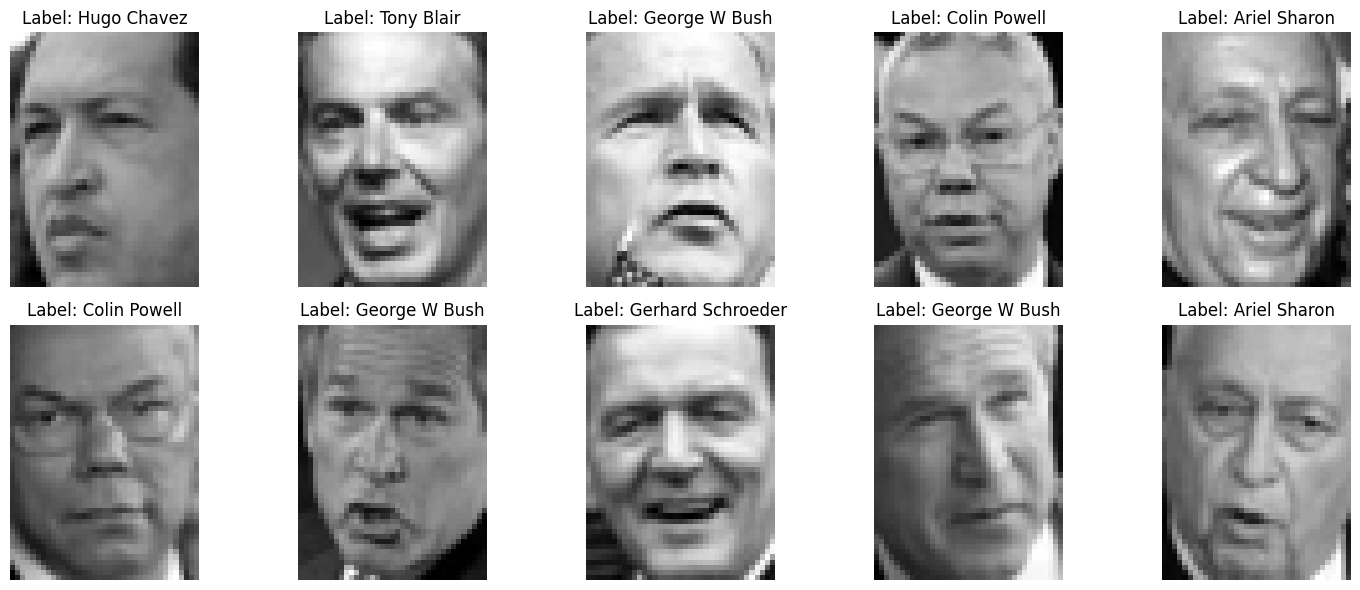

In [17]:
# Display a few images and their labels
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
for i, ax in enumerate(axes.flat):
    ax.imshow(lfw_people.images[i], cmap="gray")
    ax.set_title(f"Label: {lfw_people.target_names[y[i]]}")
    ax.axis("off")
plt.tight_layout()
plt.show()


# **Analyzing Class Distribution**

George W Bush        530
Colin Powell         236
Tony Blair           144
Donald Rumsfeld      121
Gerhard Schroeder    109
Ariel Sharon          77
Hugo Chavez           71
Name: count, dtype: int64


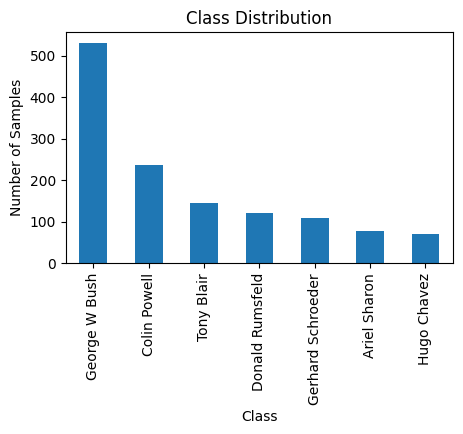

In [18]:
# Analyze class distribution
class_counts = pd.Series(y).value_counts()
class_counts.index = lfw_people.target_names[class_counts.index]
print(class_counts)

# Plot class distribution
class_counts.plot(kind='bar', figsize=(5, 3), title="Class Distribution")
plt.xlabel("Class")
plt.ylabel("Number of Samples")
plt.xticks(rotation=90)
plt.show()

# **Data augmentation And Feature Extraction**

The pretrained model InceptionV3 is used for the feature *extraction*

In [19]:
# Create an ImageDataGenerator for data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Load InceptionV3 for feature extraction
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(150, 150, 3))


87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


# **Model Architecture Extension & Creation**

In [20]:
# Add a global spatial average pooling layer and a dense layer for classification
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
predictions = Dense(n_classes, activation='softmax')(x)


# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)



# **Compile the Model**

In [21]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])



# **Model Training**

In [22]:
# Fit the model using data augmentation
print("Training model with data augmentation...")
history = model.fit(datagen.flow(X_train, y_train, batch_size=32),
                    validation_data=(X_test, y_test),
                    epochs=50,
                    steps_per_epoch=len(X_train) // 32)
print("Training completed!")

Training model with data augmentation...
Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


32/32 ━━━━━━━━━━━━━━━━━━━━ 171s 4s/step - accuracy: 0.3792 - loss: 1.7415 - val_accuracy: 0.4612 - val_loss: 1.6183
Epoch 2/50
 1/32 ━━━━━━━━━━━━━━━━━━━━ 2:11 4s/step - accuracy: 0.3125 - loss: 1.7308

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


32/32 ━━━━━━━━━━━━━━━━━━━━ 11s 231ms/step - accuracy: 0.3125 - loss: 1.7308 - val_accuracy: 0.4612 - val_loss: 1.6573
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 136s 4s/step - accuracy: 0.6221 - loss: 1.1005 - val_accuracy: 0.4612 - val_loss: 1.6571
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 11s 242ms/step - accuracy: 0.5938 - loss: 1.0215 - val_accuracy: 0.4612 - val_loss: 1.6538
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 136s 4s/step - accuracy: 0.7570 - loss: 0.7253 - val_accuracy: 0.4612 - val_loss: 2.0458
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 11s 217ms/step - accuracy: 0.8438 - loss: 0.5514 - val_accuracy: 0.4612 - val_loss: 2.0147
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 136s 4s/step - accuracy: 0.8119 - loss: 0.5297 - val_accuracy: 0.4612 - val_loss: 1.7690
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 11s 241ms/step - accuracy: 0.8438 - loss: 0.3858 - val_accuracy: 0.4612 - val_loss: 1.7768
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 190s 4s/step - accuracy: 0.8999 - loss: 0.2938 - val_accuracy: 0.4612 - val_

# **Model Evaluation**

9/9 ━━━━━━━━━━━━━━━━━━━━ 8s 832ms/step - accuracy: 0.9740 - loss: 0.0805
Accuracy: 0.97
9/9 ━━━━━━━━━━━━━━━━━━━━ 8s 851ms/step
Recall: 0.97
Precision: 0.97
F1 Score: 0.97
Confusion Matrix for SVC:
 [[  9   0   0   0   0   1   1]
 [  0  45   2   0   0   0   0]
 [  0   0  22   0   0   0   0]
 [  0   0   1 118   0   0   0]
 [  0   0   0   0  19   0   0]
 [  0   0   0   2   0  11   0]
 [  0   0   0   0   1   0  26]]


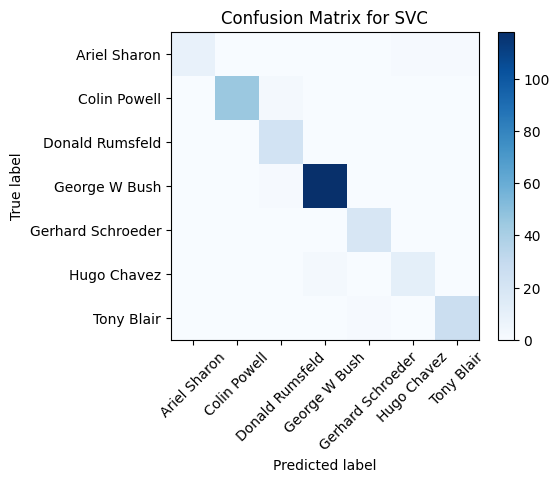

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 150, 150, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 74, 74, 32)     │            864 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 74, 74, 32)     │             96 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 74, 74, 32)     │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 72, 72, 32)     │          9,216 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 72, 72, 32)     │             96 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 72, 72, 32)     │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 72, 72, 64)     │         18,432 │ activation_1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 72, 72, 64)     │            192 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 72, 72, 64)     │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 35, 35, 64)     │              0 │ activation_2[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 35, 35, 80)     │          5,120 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 35, 35, 80)     │            240 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_3 (Activation) │ (None, 35, 35, 80)     │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 33, 33, 192)    │        138,240 │ activation_3[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4     │ (None, 33, 33, 192)    │            576 │ conv2d_4[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_4 (Activat

 Total params: 66,918,519 (255.27 MB)

 Trainable params: 22,294,695 (85.05 MB)

 Non-trainable params: 34,432 (134.50 KB)

 Optimizer params: 44,589,392 (170.10 MB)

In [24]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Accuracy: {accuracy:.2f}')

# Get predictions for calculating recall, precision, and F1 score
y_pred = np.argmax(model.predict(X_test), axis=1)

# Calculate additional metrics
recall = recall_score(y_test, y_pred, average='weighted')
precision = precision_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

# Print the additional metrics
print(f'Recall: {recall:.2f}')
print(f'Precision: {precision:.2f}')
print(f'F1 Score: {f1:.2f}')

# Confusion matrix for the SVC
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix for SVC:\n", conf_matrix)

# Visualize the confusion matrix
plt.figure(figsize=(5, 4))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix for SVC')
plt.colorbar()

# Add class labels to the axes
tick_marks = np.arange(len(target_names))
plt.xticks(tick_marks, target_names, rotation=45)
plt.yticks(tick_marks, target_names)

# Add axis labels
plt.ylabel('True label')
plt.xlabel('Predicted label')

# Display the confusion matrix
plt.show()

# Display the architecture of the Convolutional Neural Network (CNN) model
model.summary()

# **Function to calculate similarity between two images**

In [32]:
feature_extractor = Model(inputs=model.input, outputs=model.layers[-3].output)

def calculate_similarity(image1, image2, feature_extractor):
        # Extract features
        features1 = feature_extractor.predict(image1)
        features2 = feature_extractor.predict(image2)

        # Flatten the feature maps
        features1_flattened = features1.reshape(1, -1)
        features2_flattened = features2.reshape(1, -1)

        # Compute cosine similarity
        similarity = cosine_similarity(features1_flattened, features2_flattened)[0][0]

        # Define a similarity threshold
        threshold = 0.6
        is_similar = similarity >= threshold

        return is_similar, similarity


# **Testing and Results Visualization**

In [33]:
def load_image(url, target_size=(150, 150)):
    try:
        response = requests.get(url)
        response.raise_for_status()  # Raise an exception for HTTP errors
        img = Image.open(BytesIO(response.content)).convert("RGB")
        img = img.resize(target_size)  # Resize to target dimensions
        img_array = np.array(img) / 255.0  # Normalize pixel values
        return img_array
    except Exception as e:
        print(f"Error loading image: {e}")
        return None

# URLs for testing
image1_url = "https://media.allure.com/photos/57890b5c1d4bede12c872532/master/w_1600%2Cc_limit/celebrity-trends-2016-07-rihanna-face-reading.jpg"
image2_url = "https://qph.cf2.quoracdn.net/main-qimg-b6a1bfaf31909d2b8d6860e93567cb57-lq"

# Load images
image1 = load_image(image1_url)
image2 = load_image(image2_url)

if image1 is not None and image2 is not None:
    # Add batch dimension
    image1 = np.expand_dims(image1, axis=0)
    image2 = np.expand_dims(image2, axis=0)


    # Perform similarity calculation
    is_similar, similarity_score = calculate_similarity(image1, image2, feature_extractor)

    print(f"Are the images similar? {is_similar} (Similarity Score: {similarity_score:.2f})")
else:
    print("One or both images could not be loaded.")

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
Are the images similar? True (Similarity Score: 0.77)


# **Conclusion and Future Work**